# Nepali Handwritten Barnamala Recognition System

##Install Libraries and Mount Drive

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob # For listing files
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

print("--- Step 1: Installing Required Libraries ---")

if 'google.colab' in sys.modules:
    COLAB = True
    print("Google Colab environment detected.")
    !nvidia-smi # Confirm GPU
    if not os.path.exists('/opt/bin/nvidia-smi'):
        print("WARNING: GPU not detected. Please change runtime type to GPU.")
    else:
        print("GPU detected. Proceeding with cuML and TensorFlow.js installation.")
else:
    COLAB = False
    print("Not in Google Colab environment. GPU acceleration will not be applied.")

if COLAB:
    print("Installing RAPIDS cuML (if needed for other parts of your project)...")
    !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com/ --no-cache-dir

    print("Installing TensorFlow.js converter library...")
    !pip install tensorflowjs --no-cache-dir

    print("Mounting Google Drive (if your dataset is stored there)...")
    from google.colab import drive
    drive.mount('/content/drive')

    zip_path_in_drive = '/content/drive/MyDrive/DevanagariHandwrittenCharacterDataset.zip'
    unzip_dest_path = '/content/'
    print(f"Attempting to unzip {zip_path_in_drive} to {unzip_dest_path}...")
    !unzip -qq -o "{zip_path_in_drive}" -d "{unzip_dest_path}"
    print("Unzipping complete.")
    DATA_DIR = os.path.join(unzip_dest_path, 'DevanagariHandwrittenCharacterDataset')
else:
    DATA_DIR = 'C:/Users/purug/Desktop/Nepali-Baenamala/DevanagariHandwrittenCharacterDataset'

print(f"Dataset base directory set to: {DATA_DIR}")
print(f"Contents of {DATA_DIR}:")
!ls -F "{DATA_DIR}"

print("\n--- Step 1 Complete: Libraries Installed and Drive Mounted ---")

--- Step 1: Installing Required Libraries ---
Google Colab environment detected.
Wed Jul 16 10:33:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                

##Load and Preprocess Data


--- Step 2: Loading and Preprocessing Data ---

Loading Training Data...
Found 46 classes: ['character_10_yna', 'character_11_taamatar', 'character_12_thaa', 'character_13_daa', 'character_14_dhaa', 'character_15_adna', 'character_16_tabala', 'character_17_tha', 'character_18_da', 'character_19_dha', 'character_1_ka', 'character_20_na', 'character_21_pa', 'character_22_pha', 'character_23_ba', 'character_24_bha', 'character_25_ma', 'character_26_yaw', 'character_27_ra', 'character_28_la', 'character_29_waw', 'character_2_kha', 'character_30_motosaw', 'character_31_petchiryakha', 'character_32_patalosaw', 'character_33_ha', 'character_34_chhya', 'character_35_tra', 'character_36_gya', 'character_3_ga', 'character_4_gha', 'character_5_kna', 'character_6_cha', 'character_7_chha', 'character_8_ja', 'character_9_jha', 'digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9']
Training data loaded: X_train_raw shape (78200, 32, 32), y_train

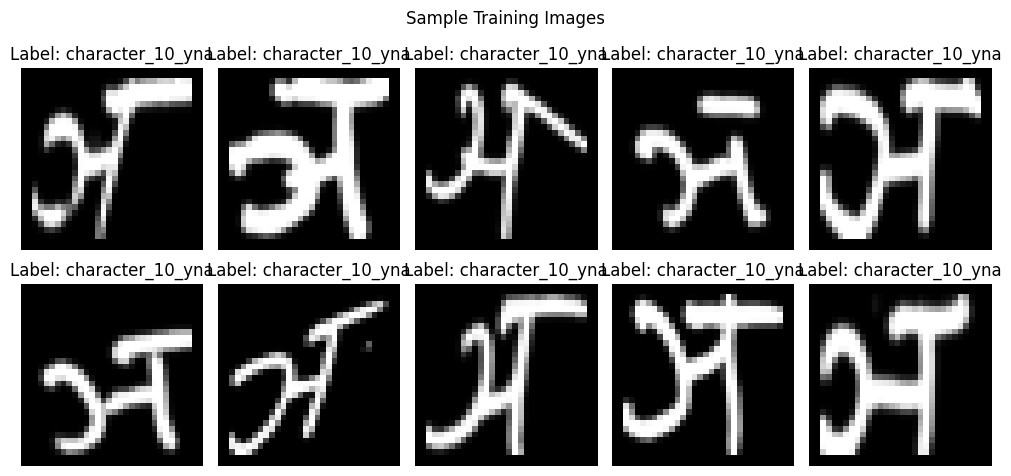


--- Step 2 Complete: Data Loaded and Preprocessed ---


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob # For listing files
from sklearn.model_selection import train_test_split # If you need to split data here
from tensorflow.keras.utils import to_categorical

print("\n--- Step 2: Loading and Preprocessing Data ---")

def load_images_from_directory(base_dir):
    images = []
    labels = []
    # Ensure class_names are sorted to maintain consistent mapping
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    class_to_idx = {name: i for i, name in enumerate(class_names)}

    print(f"Found {len(class_names)} classes: {class_names}")

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        image_files = glob.glob(os.path.join(class_dir, '*.png'))

        for img_file in image_files:
            try:
                img = Image.open(img_file).convert('L') # Grayscale
                img = img.resize((32, 32)) # Resize to 32x32
                img_array = np.array(img) # Keep as 2D array for CNN
                images.append(img_array)
                labels.append(class_to_idx[class_name])
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

    return np.array(images), np.array(labels), class_names

# Define paths for training and testing data
train_data_dir = os.path.join(DATA_DIR, 'Train')
test_data_dir = os.path.join(DATA_DIR, 'Test')

print("\nLoading Training Data...")
X_train_raw, y_train, class_names = load_images_from_directory(train_data_dir)
print(f"Training data loaded: X_train_raw shape {X_train_raw.shape}, y_train shape {y_train.shape}")

print("\nLoading Testing Data...")
X_test_raw, y_test, _ = load_images_from_directory(test_data_dir)
print(f"Testing data loaded: X_test_raw shape {X_test_raw.shape}, y_test shape {y_test.shape}")

# Normalize pixel values to [0, 1] and reshape for CNN
X_train_normalized = X_train_raw.astype('float32') / 255.0
X_test_normalized = X_test_raw.astype('float32') / 255.0

# Reshape for CNN: (num_samples, height, width, channels)
X_train_cnn = X_train_normalized.reshape(-1, 32, 32, 1)
X_test_cnn = X_test_normalized.reshape(-1, 32, 32, 1)

# Convert labels to one-hot encoding
num_classes = len(class_names)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print("\nData Preprocessing Complete:")
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_test_cnn shape: {X_test_cnn.shape}")
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")
print(f"y_test_one_hot shape: {y_test_one_hot.shape}")
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {class_names}")

# Display a few sample images to verify
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_normalized[i], cmap='gray') # Display 2D image
    plt.title(f"Label: {class_names[y_train[i]]}")
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.show()

print("\n--- Step 2 Complete: Data Loaded and Preprocessed ---")

##Define and Train CNN Model


--- Step 3: Defining and Training ENHANCED CNN Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 596,622 (2.28 MB)

 Trainable params: 595,982 (2.27 MB)

 Non-trainable params: 640 (2.50 KB)


Training ENHANCED CNN Model...
Epoch 1/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5732 - loss: 1.7031 - val_accuracy: 0.9192 - val_loss: 0.3098
Epoch 2/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9145 - loss: 0.3141 - val_accuracy: 0.9699 - val_loss: 0.1030
Epoch 3/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9465 - loss: 0.1925 - val_accuracy: 0.9828 - val_loss: 0.0616
Epoch 4/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9578 - loss: 0.1473 - val_accuracy: 0.9860 - val_loss: 0.0472
Epoch 5/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9631 - loss: 0.1223 - val_accuracy: 0.9855 - val_loss: 0.0487
Epoch 6/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9695 - loss: 0.1008 - val_accuracy: 0.9892 - val_loss: 0.0375
Epoch 7/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9719 - loss: 0.0925 - val_accuracy: 0.9849 - val_loss: 0.0545
Epoch 8/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accur

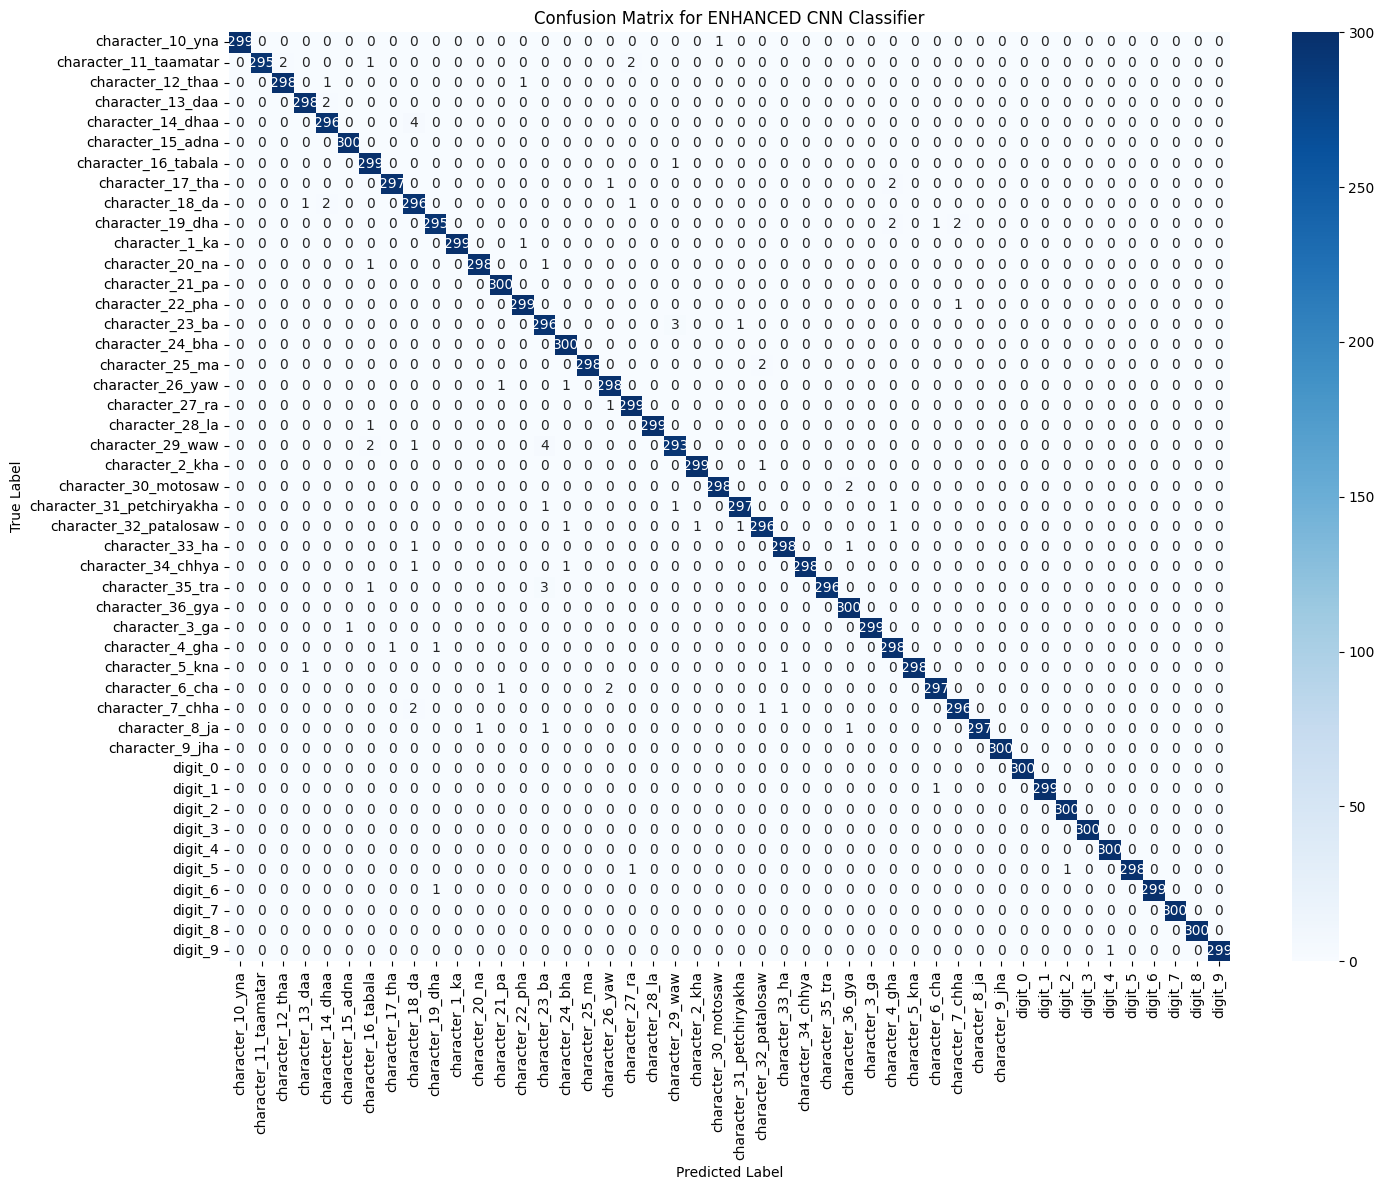


--- Plotting Training and Validation Curves ---


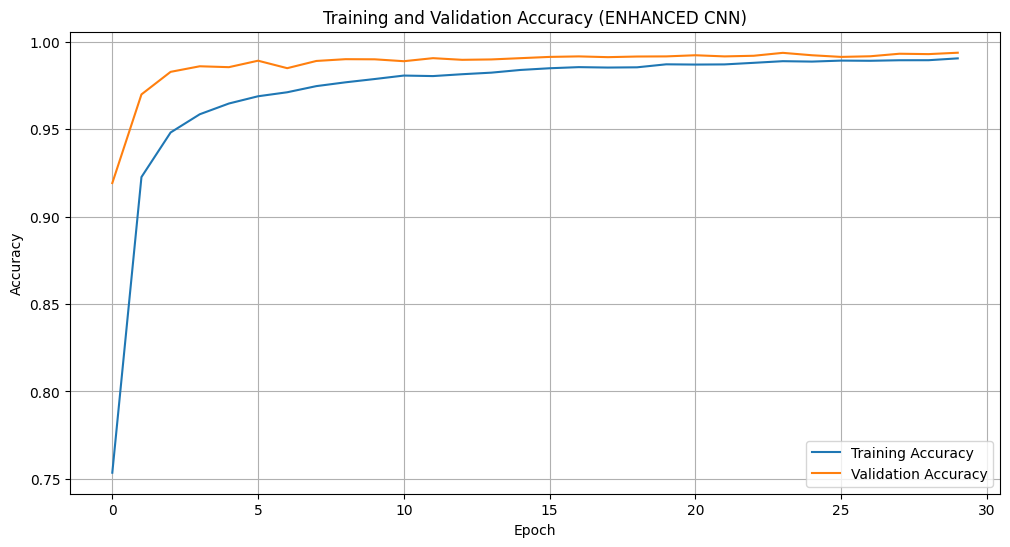

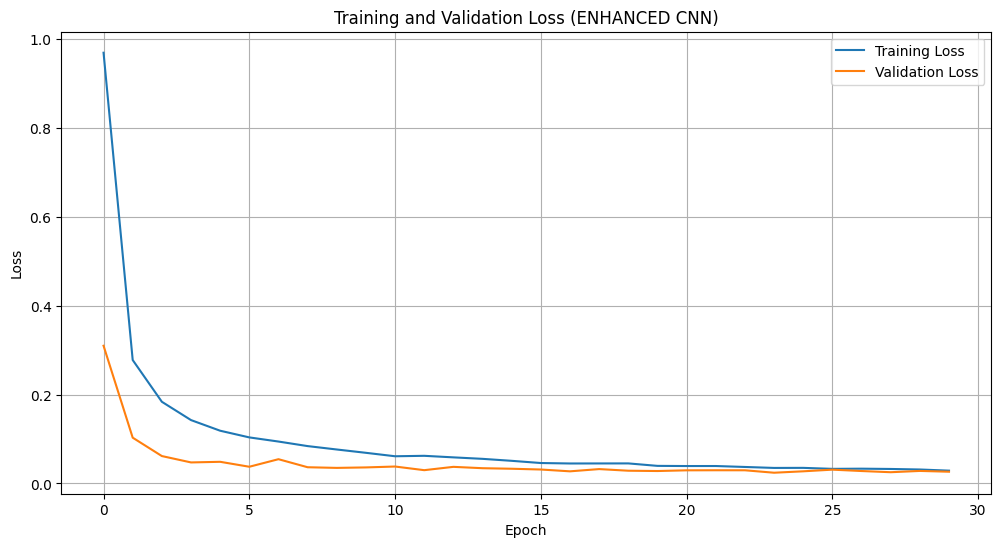


--- Step 3 Complete: CNN Model Trained and Evaluated ---


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Step 3: Defining and Training ENHANCED CNN Model ---")

# Define the CNN Model Architecture
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 1)),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the output for the Dense layers
    Flatten(),

    # Fully Connected Layers
    Dense(128),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax') # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Define training parameters
epochs = 30
batch_size = 128

# Train the model
print("\nTraining ENHANCED CNN Model...")
history = model.fit(X_train_cnn, y_train_one_hot,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_cnn, y_test_one_hot),
                    verbose=1)

print("\n--- CNN Model Training Complete ---")

# Evaluate the model on the test set
loss, accuracy_cnn = model.evaluate(X_test_cnn, y_test_one_hot, verbose=0)
print(f"\nAccuracy (CNN): {accuracy_cnn:.4f}")

# Make predictions
y_pred_cnn_probs = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

# Generate and print the Classification Report
print("\nClassification Report (ENHANCED CNN):")
print(classification_report(y_test, y_pred_cnn, target_names=class_names))

# Generate and plot the Confusion Matrix for the CNN model
print("\nGenerating Confusion Matrix for ENHANCED CNN...")
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for ENHANCED CNN Classifier')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot Training and Validation Curves
print("\n--- Plotting Training and Validation Curves ---")

epochs_range = range(epochs)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (ENHANCED CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (ENHANCED CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("\n--- Step 3 Complete: CNN Model Trained and Evaluated ---")

## Model Conversion and Download

In [4]:

import tensorflow as tf
import os
from google.colab import files # For downloading files

print("\n--- Step 4: Converting Keras Model to TensorFlow.js format ---")

# Define two separate directories:
# 1. For the intermediate TensorFlow SavedModel format
# 2. For the final TensorFlow.js output format
keras_saved_model_dir = '/content/keras_saved_model_temp'
tfjs_output_dir = '/content/tfjs_model_for_web' # This will be the folder you download!

# Clean up previous attempts in both directories
if os.path.exists(keras_saved_model_dir):
    print(f"Cleaning up existing Keras SavedModel directory: {keras_saved_model_dir}")
    !rm -rf "{keras_saved_model_dir}"
os.makedirs(keras_saved_model_dir, exist_ok=True)

if os.path.exists(tfjs_output_dir):
    print(f"Cleaning up existing TFJS output directory: {tfjs_output_dir}")
    !rm -rf "{tfjs_output_dir}"
os.makedirs(tfjs_output_dir, exist_ok=True)


print(f"Saving Keras model to TensorFlow SavedModel format in {keras_saved_model_dir}...")
# Save your trained Keras 'model' into the SavedModel format
tf.saved_model.save(model, keras_saved_model_dir)

print(f"Converting SavedModel to TensorFlow.js format and saving to {tfjs_output_dir}...")
# Now, use the converter to take the SavedModel and output the TFJS format
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='softmax' \
    "{keras_saved_model_dir}" \
    "{tfjs_output_dir}"

print("\n--- Model conversion complete! ---")
print(f"The correct files for your web app are in '{tfjs_output_dir}'.")
print("You should find 'model.json' and 'group1-shard1of1.bin' (or similar .bin files) there.")

# Zip the correct folder for easy download
print(f"\nZipping '{tfjs_output_dir}' for download...")
!zip -r /content/tfjs_model_for_web.zip "{tfjs_output_dir}"

# Offer to download the zip file
print("Initiating download of tfjs_model_for_web.zip...")
files.download('/content/tfjs_model_for_web.zip')

print("\n--- Step 4 Complete: Model Converted and Download Initiated ---")


--- Step 4: Converting Keras Model to TensorFlow.js format ---
Saving Keras model to TensorFlow SavedModel format in /content/keras_saved_model_temp...
Converting SavedModel to TensorFlow.js format and saving to /content/tfjs_model_for_web...
2025-07-16 10:40:06.278764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752662406.301559    4068 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752662406.307600    4068 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-07-16 10:40:12.309624: W tensorflow/core/common_runtime/gpu/gpu_bfc_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Step 4 Complete: Model Converted and Download Initiated ---
